In [21]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt

def load_json(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

In [22]:
tasks = load_json("../data/tasks/tasks.json")
final_labels = pd.read_csv("final_labels.csv")
final_labels = final_labels.astype({'utterance_id': 'str'})

In [23]:
utts_info = []
for corpus in ["fora", "insq"]:
    for task in tasks:
        task_id = task['task_id']
        if corpus not in task["task_id"]:
            continue
        utts = task["target_utterances"]
        for utt in utts:
            if utt["skipped"]:
                continue
            text = utt["utterance_text"]
            length = len(text.split(" "))
            conv_id = corpus + "_" + str(utt['conversation_id']).split("_")[-1]
            utts_info.append({'corpus': corpus, "conversation_id": conv_id, 'utterance_id': str(utt['utterance_id']), "text": text, "length": length, "speaker": utt['utterance_speaker'], "task_id": task_id})
utts_df = pd.DataFrame(utts_info)

In [24]:
len(utts_df)

1062

In [25]:
# Pivot so that aspects are columns
final_df = final_labels.pivot_table(
    index=["corpus", "conv_id", "utterance_id"],   # keep utterance identifiers
    columns="aspect",                              # spread aspects across columns
    values=["n_raters","y_hard","w_conf","p1","p2","p3","p4","y_cont","lo","hi",
            "mask_t1","mask_t2","mask_t3"],        # values to pivot
    aggfunc="first"                                # if duplicates, take first
)

# Flatten the multi-level column index (e.g. ('y_hard','Novelty') → 'y_hard_Novelty')
final_df.columns = [f"{val}_{aspect}" for val, aspect in final_df.columns]

# Reset index so corpus/conv_id/utterance_id are normal columns
final_df = final_df.reset_index()
final_df = pd.merge(final_df, utts_df[["utterance_id", "text", "length", "speaker", "task_id"]], how="left", on=["utterance_id"])

In [26]:
import pandas as pd

# df should have: 'corpus', 'conv_id', 'task_id', 'utterance_id', 'length', 'speaker'
df = final_df

# 1) Per-segment stats (segment = conv_id × task_id)
seg = (
    df.groupby(['corpus', 'conv_id', 'task_id'], as_index=False)
      .agg(
          utterance_count = ('utterance_id', 'size'),   # rows per segment
          unique_speakers = ('speaker', 'nunique')
      )
)

# 2) Per-corpus aggregates
by_corpus = (
    seg.groupby('corpus', as_index=False)
       .agg(
           mean_utts_per_segment   = ('utterance_count', 'mean'),
           mean_speakers_per_segment = ('unique_speakers', 'mean')
       )
       .merge(
           df.groupby('corpus', as_index=False)
             .agg(mean_words_per_utterance=('length', 'mean')),
           on='corpus'
       )
)

# 3) Overall row
overall = pd.DataFrame({
    'corpus': ['All'],
    'mean_utts_per_segment': [seg['utterance_count'].mean()],
    'mean_speakers_per_segment': [seg['unique_speakers'].mean()],
    'mean_words_per_utterance': [df['length'].mean()]
})

summary = pd.concat([by_corpus, overall], ignore_index=True)

# 4) Round and pretty columns
summary = summary.round(2).rename(columns={
    'corpus': 'Corpus',
    'mean_utts_per_segment': 'Mean utts/segment',
    'mean_speakers_per_segment': 'Mean unique speakers/segment',
    'mean_words_per_utterance': 'Mean words/utterance'
})

summary


,Corpus,Mean utts/segment,Mean unique speakers/segment,Mean words/utterance
0,fora,7.82,3.60,74.86
1,insq,6.40,3.08,73.29
2,All,7.11,3.34,74.15


In [27]:
latex = summary.to_latex(
    index=False,
    caption="Descriptive statistics by corpus and overall.",
    label="tab:desc_stats",
    escape=False
)
print(latex)

\begin{table}
\caption{Descriptive statistics by corpus and overall.}
\label{tab:desc_stats}
\begin{tabular}{lrrr}
\toprule
Corpus & Mean utts/segment & Mean unique speakers/segment & Mean words/utterance \\
\midrule
fora & 7.820000 & 3.600000 & 74.860000 \\
insq & 6.400000 & 3.080000 & 73.290000 \\
All & 7.110000 & 3.340000 & 74.150000 \\
\bottomrule
\end{tabular}
\end{table}



In [28]:
final_df.columns

Index(['corpus', 'conv_id', 'utterance_id', 'hi_CIG', 'hi_Novelty',
       'hi_Relevance', 'hi_Scope', 'lo_CIG', 'lo_Novelty', 'lo_Relevance',
       'lo_Scope', 'mask_t1_CIG', 'mask_t1_Novelty', 'mask_t1_Relevance',
       'mask_t1_Scope', 'mask_t2_CIG', 'mask_t2_Novelty', 'mask_t2_Relevance',
       'mask_t2_Scope', 'mask_t3_CIG', 'mask_t3_Novelty', 'mask_t3_Relevance',
       'mask_t3_Scope', 'n_raters_CIG', 'n_raters_Novelty',
       'n_raters_Relevance', 'n_raters_Scope', 'p1_CIG', 'p1_Novelty',
       'p1_Relevance', 'p1_Scope', 'p2_CIG', 'p2_Novelty', 'p2_Relevance',
       'p2_Scope', 'p3_CIG', 'p3_Novelty', 'p3_Relevance', 'p3_Scope',
       'p4_CIG', 'p4_Novelty', 'p4_Relevance', 'p4_Scope', 'w_conf_CIG',
       'w_conf_Novelty', 'w_conf_Relevance', 'w_conf_Scope', 'y_cont_CIG',
       'y_cont_Novelty', 'y_cont_Relevance', 'y_cont_Scope', 'y_hard_CIG',
       'y_hard_Novelty', 'y_hard_Relevance', 'y_hard_Scope', 'text', 'length',
       'speaker', 'task_id'],
      dtype='obj

In [29]:
'corpus', 'conv_id', 'utterance_id', 'length', "speaker"

('corpus', 'conv_id', 'utterance_id', 'length', 'speaker')

In [30]:
# use soft label
soft_df = final_df[['corpus', 'conv_id', 'utterance_id', 'y_cont_CIG',
       'y_cont_Novelty', 'y_cont_Relevance', 'y_cont_Scope', "text", "length"]]
soft_df = soft_df.rename(columns={'y_cont_CIG': 'info', 'y_cont_Novelty': 'novo', 'y_cont_Relevance':"relv", "y_cont_Scope": "imsc"})

In [31]:
# use hard labels
hard_df = final_df[['corpus', 'conv_id', 'utterance_id', 'y_hard_CIG',
       'y_hard_Novelty', 'y_hard_Relevance', 'y_hard_Scope', "text", "length"]]

hard_df = hard_df.rename(columns={'y_hard_CIG': 'info', 'y_hard_Novelty': 'novo', 'y_hard_Relevance':"relv", "y_hard_Scope": "imsc"})

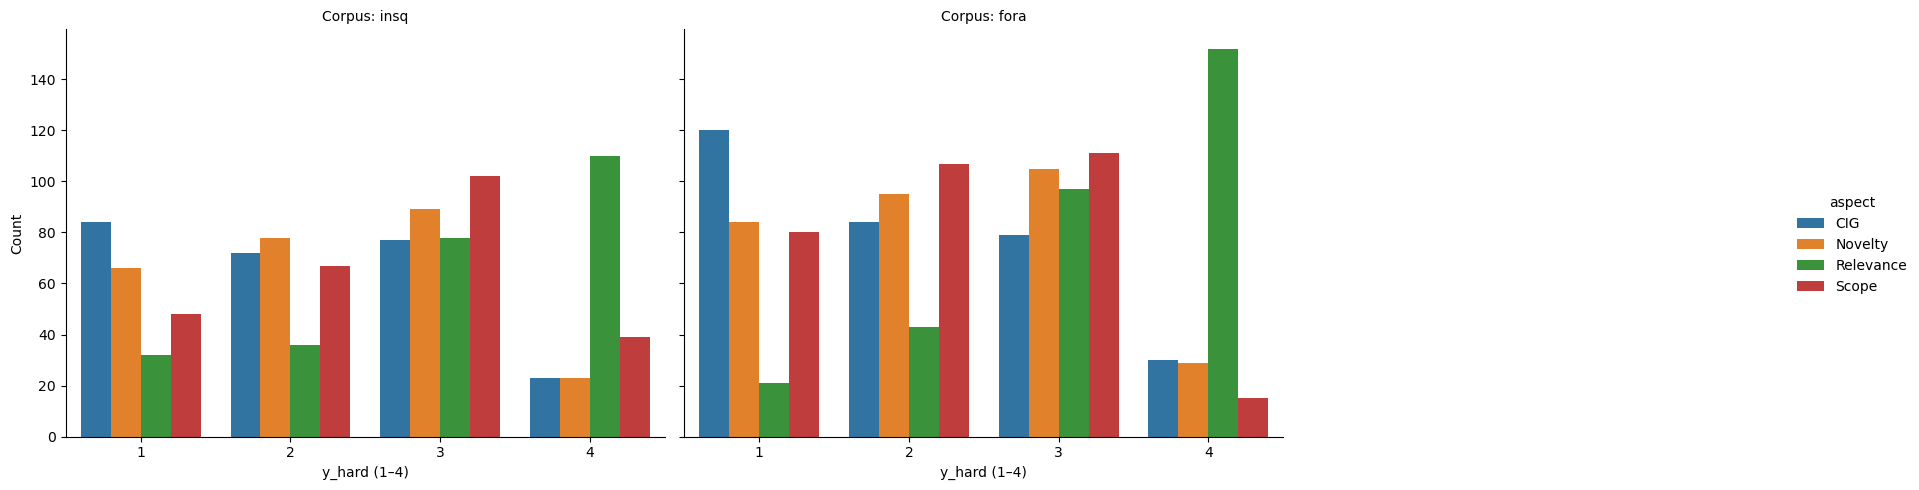

In [32]:
df = final_labels
# Make sure y_hard is treated as categorical (ordinal 1–4)
df["y_hard"] = df["y_hard"].astype("category")

# Plot distributions
g = sns.catplot(
    data=df,
    x="y_hard",
    hue="aspect",
    col="corpus",
    kind="count",
    col_wrap=3,     # wrap into rows if many corpora
    height=5,
    aspect=1.2
)

g.set_axis_labels("y_hard (1–4)", "Count")
g.set_titles("Corpus: {col_name}")
plt.tight_layout()
plt.show()

In [33]:
final_df.conv_id.unique()

array(['fora_2187', 'fora_2188', 'fora_2239', 'fora_2246', 'fora_2359',
       'fora_2361', 'fora_2409', 'fora_2429', 'fora_2700', 'fora_2733',
       'insq_16966', 'insq_17957', 'insq_20148', 'insq_2228',
       'insq_23135', 'insq_24367', 'insq_26062', 'insq_5180', 'insq_9437',
       'insq_9973'], dtype=object)

count    569.000000
mean      74.152900
std       93.200089
min        1.000000
25%       10.000000
50%       36.000000
75%      108.000000
max      648.000000
Name: length, dtype: float64


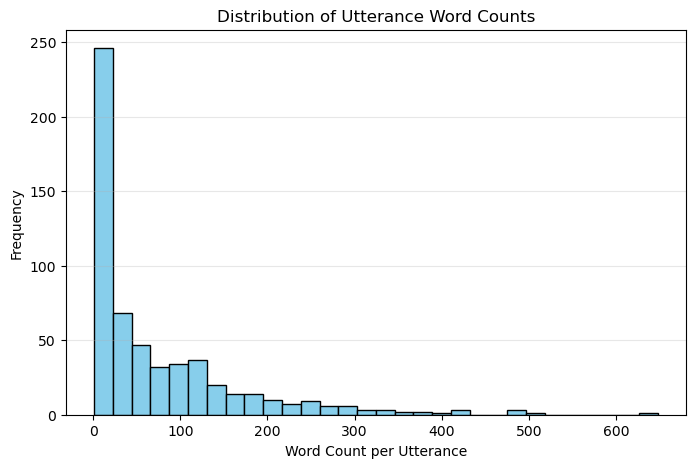

In [34]:
print(final_df['length'].describe())  # mean, std, quartiles

# histogram
plt.figure(figsize=(8,5))
plt.hist(final_df['length'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Word Count per Utterance')
plt.ylabel('Frequency')
plt.title('Distribution of Utterance Word Counts')
plt.grid(axis='y', alpha=0.3)
plt.show()

In [35]:
# final_df = final_df[(final_df.length >= 20) & (final_df.length <=50)]

## Construct Validity

### Multicullinearity check

#### Full

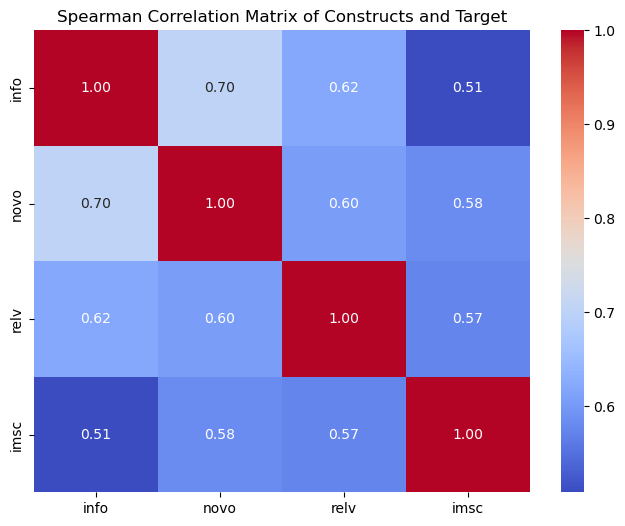

In [36]:
df = soft_df
# Select the variables of interest
constructs_and_target = ['info', 'novo', 'relv', 'imsc']

# Calculate Spearman correlation
corr_matrix = df[constructs_and_target].corr(method='spearman')

# Visualize the correlation matrix with a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Spearman Correlation Matrix of Constructs and Target')
plt.show()

#### INSQ dataset

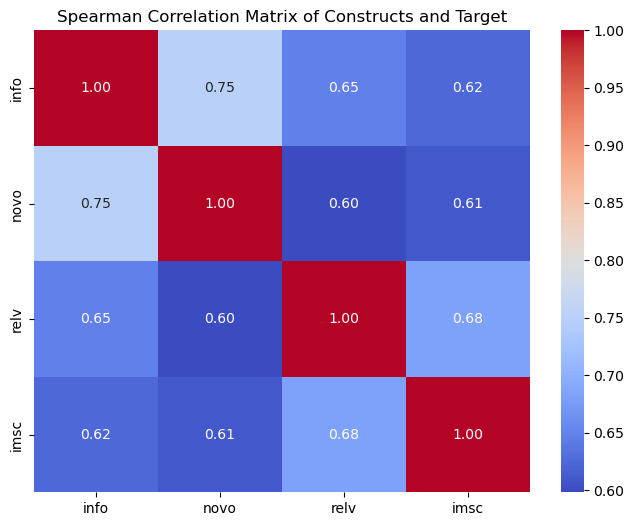

In [37]:
df = soft_df[soft_df.corpus == "insq"]
# Select the variables of interest
constructs_and_target = ['info', 'novo', 'relv', 'imsc']

# Calculate Spearman correlation
corr_matrix = df[constructs_and_target].corr(method='spearman')

# Visualize the correlation matrix with a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Spearman Correlation Matrix of Constructs and Target')
plt.show()

#### Fora dataset

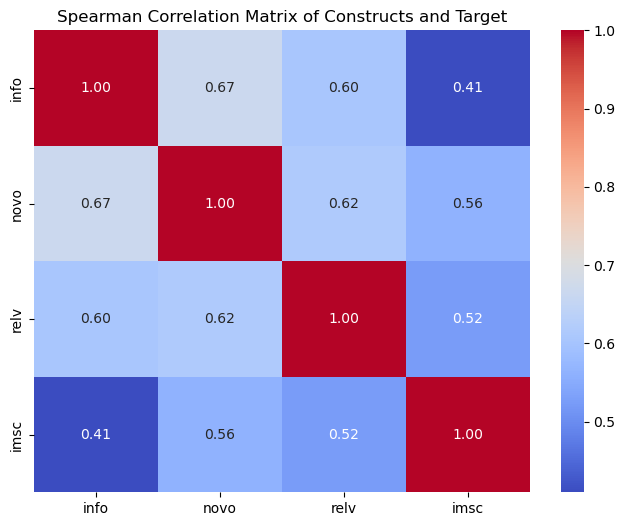

In [38]:
df = soft_df[soft_df.corpus == "fora"]
# Select the variables of interest
constructs_and_target = ['info', 'novo', 'relv', 'imsc']

# Calculate Spearman correlation
corr_matrix = df[constructs_and_target].corr(method='spearman')

# Visualize the correlation matrix with a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Spearman Correlation Matrix of Constructs and Target')
plt.show()

## Feature Importances

In [39]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.inspection import permutation_importance
from scipy.stats import ttest_rel

def check_randomforest_fi(df):
    # --- Model Comparison Setup ---
    # Define features and target
    X = df.drop('info', axis=1)
    y = df['info']

    base_features = ['length']
    construct_features = ['novo', 'relv', 'imsc']

    # We'll use a robust model that can handle interactions and non-linearities
    # without requiring feature scaling.
    model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Use Stratified K-Fold for cross-validation to preserve class distribution
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    # --- Evaluate the Baseline Model ---
    base_scores = cross_val_score(model, X[base_features], y, cv=cv, scoring='accuracy')
    print(f"Baseline Model (features: {base_features})")
    print(f"Mean CV Accuracy: {np.mean(base_scores):.4f} (+/- {np.std(base_scores):.4f})\n")
    

    # --- Evaluate Each Augmented Model and Test for Significance ---
    results = {}
    for construct in construct_features:
        augmented_features = base_features + [construct]

        # Evaluate the augmented model
        augmented_scores = cross_val_score(model, X[augmented_features], y, cv=cv, scoring='accuracy')

        # Perform a paired t-test on the cross-validation scores
        # This checks if the difference in scores between the two models is statistically significant
        t_stat, p_value = ttest_rel(augmented_scores, base_scores)

        print(f"--- Validating '{construct}' ---")
        print(f"Augmented Model (features: {augmented_features})")
        print(f"Mean CV Accuracy: {np.mean(augmented_scores):.4f} (+/- {np.std(augmented_scores):.4f})")
        print(f"Improvement over Baseline: {np.mean(augmented_scores) - np.mean(base_scores):.4f}")
        print(f"Paired t-test p-value: {p_value:.6f}")

        if p_value < 0.05:
            print("Result: The improvement is statistically significant. The construct adds predictive power.\n")
        else:
            print("Result: The improvement is NOT statistically significant.\n")

        results[construct] = {'scores': augmented_scores, 'p_value': p_value}
    
    # --- Full Model with All Features ---
    all_features =  base_features + construct_features
    X_full = df[all_features] # Use df instead of X to be clear
    
    # Evaluate the augmented model
    augmented_scores = cross_val_score(model,X_full, y, cv=cv, scoring='accuracy')

    # Perform a paired t-test on the cross-validation scores
    # This checks if the difference in scores between the two models is statistically significant
    t_stat, p_value = ttest_rel(augmented_scores, base_scores)

    print(f"--- Validating 'full features' ---")
    print(f"Augmented Model (features: {all_features})")
    print(f"Mean CV Accuracy: {np.mean(augmented_scores):.4f} (+/- {np.std(augmented_scores):.4f})")
    print(f"Improvement over Baseline: {np.mean(augmented_scores) - np.mean(base_scores):.4f}")
    print(f"Paired t-test p-value: {p_value:.6f}")

    if p_value < 0.05:
        print("Result: The improvement is statistically significant. The construct adds predictive power.\n")
    else:
        print("Result: The improvement is NOT statistically significant.\n")

    # Train the model on the full dataset to get importance scores
    full_model = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_full, y)

    # Calculate Permutation Importance
    # CHANGE IS HERE: n_jobs=1 instead of n_jobs=-1
    perm_importance = permutation_importance(
        full_model, X_full, y, n_repeats=10, random_state=42, n_jobs=1
    )

    # The rest of the code remains the same
    sorted_idx = perm_importance.importances_mean.argsort()

    # Plot the results
    plt.figure(figsize=(10, 6))
    # Use .iloc/.columns to be explicit with pandas
    plt.barh(X_full.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
    plt.xlabel("Permutation Importance")
    plt.title("Feature Importance in the Full Model")
    plt.show()

In [40]:
rows_with_nan = final_df[final_df.isnull().any(axis=1)]


#### Full

Baseline Model (features: ['length'])
Mean CV Accuracy: 0.5430 (+/- 0.0339)

--- Validating 'novo' ---
Augmented Model (features: ['length', 'novo'])
Mean CV Accuracy: 0.5852 (+/- 0.0467)
Improvement over Baseline: 0.0423
Paired t-test p-value: 0.010760
Result: The improvement is statistically significant. The construct adds predictive power.

--- Validating 'relv' ---
Augmented Model (features: ['length', 'relv'])
Mean CV Accuracy: 0.5291 (+/- 0.0660)
Improvement over Baseline: -0.0139
Paired t-test p-value: 0.586099
Result: The improvement is NOT statistically significant.

--- Validating 'imsc' ---
Augmented Model (features: ['length', 'imsc'])
Mean CV Accuracy: 0.5553 (+/- 0.0447)
Improvement over Baseline: 0.0124
Paired t-test p-value: 0.479664
Result: The improvement is NOT statistically significant.

--- Validating 'full features' ---
Augmented Model (features: ['length', 'novo', 'relv', 'imsc'])
Mean CV Accuracy: 0.5959 (+/- 0.0677)
Improvement over Baseline: 0.0530
Paired t-te

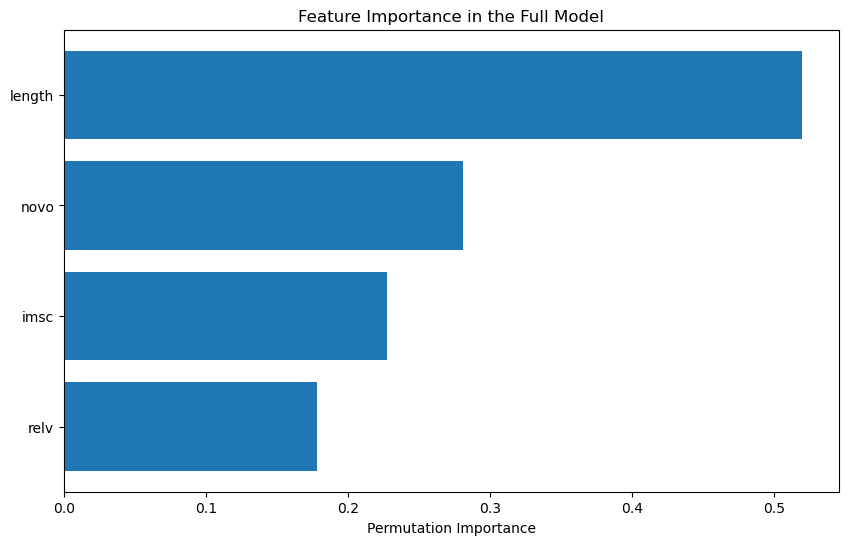

In [41]:
check_randomforest_fi(hard_df)

#### INSQ

Baseline Model (features: ['length'])
Mean CV Accuracy: 0.5828 (+/- 0.0521)

--- Validating 'novo' ---
Augmented Model (features: ['length', 'novo'])
Mean CV Accuracy: 0.5982 (+/- 0.0482)
Improvement over Baseline: 0.0154
Paired t-test p-value: 0.377695
Result: The improvement is NOT statistically significant.

--- Validating 'relv' ---
Augmented Model (features: ['length', 'relv'])
Mean CV Accuracy: 0.5514 (+/- 0.0533)
Improvement over Baseline: -0.0314
Paired t-test p-value: 0.219976
Result: The improvement is NOT statistically significant.

--- Validating 'imsc' ---
Augmented Model (features: ['length', 'imsc'])
Mean CV Accuracy: 0.6018 (+/- 0.0569)
Improvement over Baseline: 0.0191
Paired t-test p-value: 0.388325
Result: The improvement is NOT statistically significant.

--- Validating 'full features' ---
Augmented Model (features: ['length', 'novo', 'relv', 'imsc'])
Mean CV Accuracy: 0.6294 (+/- 0.0645)
Improvement over Baseline: 0.0466
Paired t-test p-value: 0.138536
Result: The 

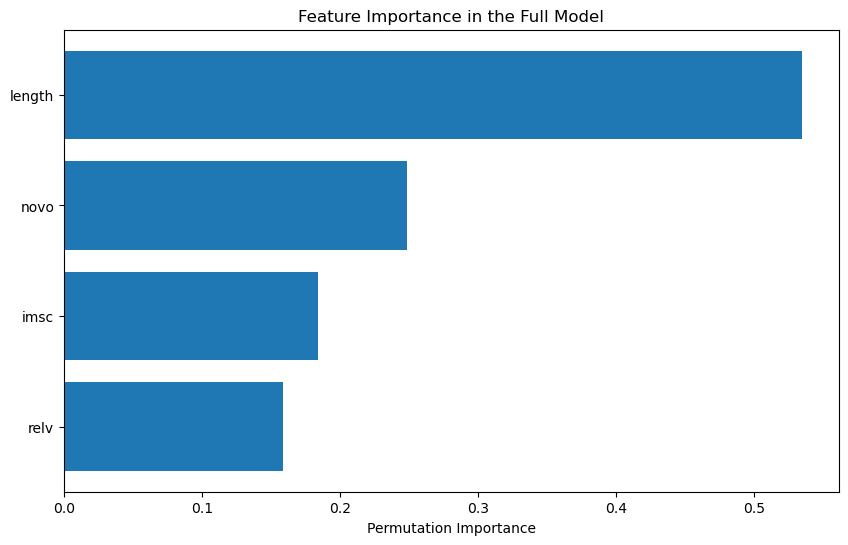

In [42]:
check_randomforest_fi(hard_df[hard_df.corpus == "insq"])

#### Fora

Baseline Model (features: ['length'])
Mean CV Accuracy: 0.5403 (+/- 0.0944)

--- Validating 'novo' ---
Augmented Model (features: ['length', 'novo'])
Mean CV Accuracy: 0.6169 (+/- 0.1219)
Improvement over Baseline: 0.0766
Paired t-test p-value: 0.027942
Result: The improvement is statistically significant. The construct adds predictive power.

--- Validating 'relv' ---
Augmented Model (features: ['length', 'relv'])
Mean CV Accuracy: 0.5208 (+/- 0.0493)
Improvement over Baseline: -0.0196
Paired t-test p-value: 0.441778
Result: The improvement is NOT statistically significant.

--- Validating 'imsc' ---
Augmented Model (features: ['length', 'imsc'])
Mean CV Accuracy: 0.5563 (+/- 0.0817)
Improvement over Baseline: 0.0159
Paired t-test p-value: 0.573516
Result: The improvement is NOT statistically significant.

--- Validating 'full features' ---
Augmented Model (features: ['length', 'novo', 'relv', 'imsc'])
Mean CV Accuracy: 0.5946 (+/- 0.0760)
Improvement over Baseline: 0.0542
Paired t-te

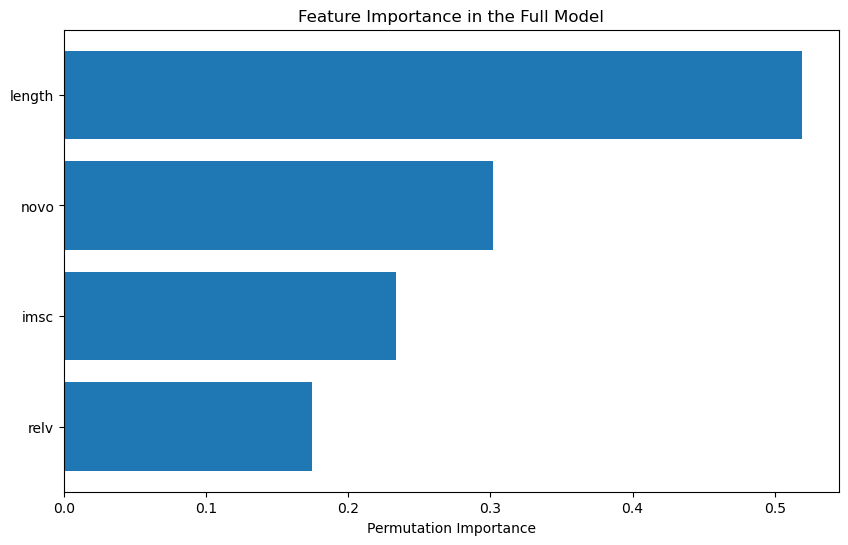

In [43]:
check_randomforest_fi(hard_df[hard_df.corpus == "fora"])

## Ordinal Regression: Additive and Interaction effect of the aspects

In [44]:
import numpy as np
import pandas as pd
from statsmodels.miscmodels.ordinal_model import OrderedModel
from scipy.stats import chi2
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

# ----- fit helpers -----
def fit_ordlogit(y, X, name, link='logit'):
    mod = OrderedModel(y, X, distr=link)
    res = mod.fit(method='bfgs', maxiter=200, disp=False)
    return dict(name=name, res=res, k=X.shape[1], X=X)

def lr_test(full, reduced):
    chi2_stat = 2*(full['res'].llf - reduced['res'].llf)
    df = full['k'] - reduced['k']
    p = chi2.sf(chi2_stat, df)
    return chi2_stat, df, p

def comp_row(m): 
    return [m['name'], float(m['res'].llf), float(m['res'].aic), float(m['res'].bic), m['k']]

# ----- CV helper (returns mean±std NLL) -----
def cv_nll(y, X, k=5, seed=42, link='logit'):
    y = y.reset_index(drop=True)
    X = X.reset_index(drop=True)
    kf = KFold(k, shuffle=True, random_state=seed)
    nlls = []
    eps = 1e-12
    for tr, te in kf.split(X):
        y_tr, y_te = y.iloc[tr], y.iloc[te]
        X_tr, X_te = X.iloc[tr], X.iloc[te]

        train_classes = np.sort(y_tr.unique())
        class_to_idx = {c: i for i, c in enumerate(train_classes)}

        mod = OrderedModel(y_tr, X_tr, distr=link)
        res = mod.fit(method='bfgs', maxiter=200, disp=False)

        P = res.model.predict(res.params, exog=X_te)  # (n_test x K_train)
        mask_seen = y_te.isin(train_classes).values
        if not mask_seen.all():
            P = P[mask_seen]
            y_te = y_te[mask_seen]

        idx = np.array([class_to_idx[int(c)] for c in y_te.values], dtype=int)
        probs = P[np.arange(P.shape[0], dtype=int), idx]
        probs = np.clip(probs, eps, 1.0)
        nlls.append(float(-np.log(probs).mean()))
    return float(np.mean(nlls)), float(np.std(nlls))


In [45]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from scipy.stats import chi2, ttest_rel
from statsmodels.miscmodels.ordinal_model import OrderedModel

def compare_ordinal_models(df, target='info',
                           predictors=['length','novo','relv','imsc'],
                           k_folds=10, random_state=42):
    """
    Compare an ordered-logit model with length only vs. length + constructs.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with the ordinal target and predictor columns.
    target : str
        Dependent variable (must be ordinal integers 1..K).
    predictors : list
        Predictors for the full model; must include 'length'.
    k_folds : int
        Number of folds for cross-validation.

    Returns
    -------
    dict of summaries, LR test, AIC/BIC, CV NLL, and paired t-test of NLL diff.
    """
    # --- Clean data ---
    cols = [target] + predictors
    data = df[cols].apply(pd.to_numeric, errors='coerce').dropna()
    y = data[target].astype(int)               # ensure integer categories
    X_all = data[predictors].astype(float)

    # --- Fit base and full models ---
    base = OrderedModel(y, X_all[['length']], distr='logit').fit(method='bfgs', disp=False)
    full = OrderedModel(y, X_all, distr='logit').fit(method='bfgs', disp=False)

    # Likelihood-ratio test
    LR = 2 * (full.llf - base.llf)
    df_diff = int(full.df_model - base.df_model)
    p_LR = chi2.sf(LR, df_diff)

    # --- 10-fold CV Negative Log-Likelihood ---
    def cv_nll(cols):
        kf = KFold(n_splits=k_folds, shuffle=True, random_state=random_state)
        nlls = []
        for tr, te in kf.split(X_all):
            mod = OrderedModel(y.iloc[tr], X_all.iloc[tr][cols], distr='logit')
            res = mod.fit(method='bfgs', disp=False)
            # predicted probabilities for the true class
            P = mod.predict(res.params, exog=X_all.iloc[te][cols])
            idx = y.iloc[te].values - 1  # convert 1..K to 0-based
            probs = P[np.arange(len(te)), idx]
            nlls.append(-np.log(probs).mean())
        return np.array(nlls)

    nll_base = cv_nll(['length'])
    nll_full = cv_nll(predictors)

    diffs = nll_base - nll_full
    t_stat, p_t = ttest_rel(nll_base, nll_full)

    return {
        "base_summary": base.summary(),
        "full_summary": full.summary(),
        "LR_test": {"LR": LR, "df": df_diff, "p": p_LR},
        "AIC_BIC": {
            "base_AIC": base.aic, "full_AIC": full.aic,
            "base_BIC": base.bic, "full_BIC": full.bic
        },
        "CV_NLL": {
            "base_mean": nll_base.mean(), "full_mean": nll_full.mean(),
            "base_sd": nll_base.std(ddof=1), "full_sd": nll_full.std(ddof=1),
            "mean_diff": diffs.mean()
        },
        "Paired_t": {"t": t_stat, "p": p_t}
    }


In [46]:
def test_additive_interact_power(df):
    # standardize constructs for stability, then make 2-way interactions
    scaler = StandardScaler()
    Z = df[['novo','relv','imsc', "length"]].astype(float).copy()
    Z[['novo','relv','imsc', "length"]] = scaler.fit_transform(Z[['novo','relv','imsc', "length"]])
    Z['novo_relv'] = Z['novo']*Z['relv']
    Z['novo_imsc'] = Z['novo']*Z['imsc']
    Z['relv_imsc'] = Z['relv']*Z['imsc']

    # ---- two-way aggregations ----
    pairs = [('novo','relv'), ('novo','imsc'), ('relv','imsc')]

    # Create 2-way aggregations
    for a,b in pairs:
        Z[f'min_{a}_{b}']  = df[[a,b]].min(axis=1)
        Z[f'max_{a}_{b}']  = df[[a,b]].max(axis=1)
        Z[f'mean_{a}_{b}'] = df[[a,b]].mean(axis=1)
        Z[f'prod_{a}_{b}'] = (df[a] * df[b]).astype(float)
        # geometric mean (smoother than product; handles zeros with small epsilon)
        Z[f'gmean_{a}_{b}'] = (Z[f'prod_{a}_{b}'].replace(0, 1e-9)) ** 0.5  # sqrt(prod)


    # ---- three-way aggregations (built from UNscaled originals) ----
    Z['min_agg']  = df[['novo','relv','imsc']].min(axis=1)
    Z['max_agg']  = df[['novo','relv','imsc']].max(axis=1)
    Z['mean_agg'] = df[['novo','relv','imsc']].mean(axis=1)
    Z['prod_agg'] = (df['novo'] * df['relv'] * df['imsc']).astype(float)
    Z['gmean_agg'] = (Z['prod_agg'].replace(0, 1e-9)) ** (1/3)

    print("Additive power test")
    models = []

    # y and baseline features
    y = df['info']  # assumes values in {1,2,3,4}
    X_B1 = df[["length"]]  # <- your simple baseline names here

    B1 = fit_ordlogit(y, X_B1, 'Base model')
    models.append(B1)

    M_novo = fit_ordlogit(y, Z[['novo']], 'Single(novo)')
    M_relv = fit_ordlogit(y, Z[['relv']], 'Single(relv)')
    M_imsc = fit_ordlogit(y, Z[['imsc']], 'Single(imsc)')
    models.extend([M_novo, M_relv, M_imsc])

    I_novo = fit_ordlogit(y, pd.concat([X_B1, Z[['novo']]], axis=1), 'Base+novo')
    I_relv = fit_ordlogit(y, pd.concat([X_B1, Z[['relv']]], axis=1), 'Base+relv')
    I_imsc = fit_ordlogit(y, pd.concat([X_B1, Z[['imsc']]], axis=1), 'Base+imsc')
    models.extend([I_novo, I_relv, I_imsc])


    # Ablation models
    Abl_novo = fit_ordlogit(y, pd.concat([X_B1, Z[['relv','imsc']]], axis=1), 'Ablation(-novo)')
    Abl_relv = fit_ordlogit(y, pd.concat([X_B1, Z[['novo','imsc']]], axis=1), 'Ablation(-relv)')
    Abl_imsc = fit_ordlogit(y, pd.concat([X_B1, Z[['novo','relv']]], axis=1), 'Ablation(-imsc)')
    models.extend([Abl_novo, Abl_relv, Abl_imsc])

    C1 = fit_ordlogit(y, pd.concat([X_B1, Z[['novo','relv','imsc']]], axis=1), 'base+3')
    C1_ = fit_ordlogit(y, Z[['novo','relv','imsc']], 'Only3')

    models.append(C1)
    models.append(C1_)

    comp_abl = pd.DataFrame(
        [comp_row(m) for m in models],
        columns=['Model','LL','AIC','BIC','Params']
    ).sort_values('AIC')
    print(comp_abl)
    
    print("Interactive power test")
    
    models = []

    models.append(C1_)

    pro2 = fit_ordlogit(y, Z[["length", 'novo','relv','imsc','prod_novo_relv','prod_novo_imsc','prod_relv_imsc']],
                      '3+prod2ways')

    min2 = fit_ordlogit(y, Z[["length", 'novo','relv','imsc','min_novo_relv','min_novo_imsc','min_relv_imsc']],
                      '3+min2ways')

    max2 = fit_ordlogit(y, Z[["length", 'novo','relv','imsc','max_novo_relv','max_novo_imsc','max_relv_imsc']],
                      '3+max2ways')

    pro3 = fit_ordlogit(y, Z[["length", 'novo','relv','imsc', "prod_agg"]],
                      '3+prod3ways')

    min3 = fit_ordlogit(y, Z[["length", 'novo','relv','imsc', "min_agg"]],
                      '3+min3ways')

    max3 = fit_ordlogit(y, Z[["length", 'novo','relv','imsc',"max_agg"]],
                      '3+max3ways')

    pro3only = fit_ordlogit(y, Z[["length", "prod_agg"]],
                      'prod3waysonly')

    min3only = fit_ordlogit(y, Z[["length", "min_agg"]],
                      'min3waysonly')

    max3only = fit_ordlogit(y, Z[["length", "max_agg"]],
                      'max3waysonly')

    models.extend([pro2, min2, max2, pro3, min3, max3, pro3only, min3only, max3only])

    comp_abl = pd.DataFrame(
        [comp_row(m) for m in models],
        columns=['Model','LL','AIC','BIC','Params']
    ).sort_values('AIC')
    print(comp_abl)
    return C1, pro2

In [47]:
# final_df["imsc"] = final_df["imsc"].clip(upper=3)
# final_df["info"] = final_df["info"].clip(upper=3)
# final_df["relv"] = final_df["relv"].clip(upper=3)
# final_df["novo"] = final_df["novo"].clip(upper=3)

In [48]:
m, prod2ways = test_additive_interact_power(hard_df)

Additive power test
              Model          LL          AIC          BIC  Params
9   Ablation(-imsc) -498.420428  1008.840857  1034.904139       3
10           base+3 -498.255597  1010.511195  1040.918358       4
8   Ablation(-relv) -512.406269  1036.812538  1062.875821       3
4         Base+novo -515.625154  1041.250308  1062.969710       2
7   Ablation(-novo) -525.746634  1063.493268  1089.556550       3
5         Base+relv -529.210724  1068.421447  1090.140850       2
11            Only3 -549.680180  1111.360360  1137.423642       3
6         Base+imsc -550.983798  1111.967597  1133.686999       2
0        Base model -571.648052  1151.296103  1168.671625       1
1      Single(novo) -582.852338  1173.704676  1191.080198       1
2      Single(relv) -618.880057  1245.760115  1263.135636       1
3      Single(imsc) -669.161010  1346.322020  1363.697542       1
Interactive power test
           Model          LL          AIC          BIC  Params
4    3+prod3ways -494.374682  1004.7

In [49]:
print(m['res'].summary())

                             OrderedModel Results                             
Dep. Variable:                   info   Log-Likelihood:                -498.26
Model:                   OrderedModel   AIC:                             1011.
Method:            Maximum Likelihood   BIC:                             1041.
Date:                Mon, 06 Oct 2025                                         
Time:                        22:50:05                                         
No. Observations:                 569                                         
Df Residuals:                     562                                         
Df Model:                           4                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
length         0.0133      0.002      8.716      0.000       0.010       0.016
novo           0.8894      0.123      7.211      0.0

In [50]:
m, prod2ways = test_additive_interact_power(hard_df[hard_df.corpus == "insq"])

Additive power test
              Model          LL         AIC         BIC  Params
9   Ablation(-imsc) -202.005032  416.010063  437.281128       3
10           base+3 -201.298640  416.597281  441.413523       4
8   Ablation(-relv) -204.105964  420.211928  441.482993       3
4         Base+novo -207.195252  424.390504  442.116391       2
7   Ablation(-novo) -213.131775  438.263549  459.534614       3
5         Base+relv -217.145337  444.290674  462.016562       2
6         Base+imsc -217.959082  445.918164  463.644051       2
0        Base model -232.292005  472.584011  486.764721       1
11            Only3 -241.881382  495.762764  517.033829       3
1      Single(novo) -256.950999  521.901998  536.082708       1
2      Single(relv) -278.309222  564.618443  578.799153       1
3      Single(imsc) -283.059378  574.118757  588.299466       1
Interactive power test
           Model          LL         AIC         BIC  Params
4    3+prod3ways -200.560171  417.120343  445.481762       5
5  

In [31]:
print(m['res'].summary())

                             OrderedModel Results                             
Dep. Variable:                   info   Log-Likelihood:                -215.90
Model:                   OrderedModel   AIC:                             445.8
Method:            Maximum Likelihood   BIC:                             470.6
Date:                Mon, 22 Sep 2025                                         
Time:                        22:16:46                                         
No. Observations:                 256                                         
Df Residuals:                     249                                         
Df Model:                           4                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
length         0.0215      0.003      7.002      0.000       0.015       0.027
novo           0.5571      0.194      2.871      0.0

In [298]:
print(prod2ways['res'].summary())

                             OrderedModel Results                             
Dep. Variable:                   info   Log-Likelihood:                -163.58
Model:                   OrderedModel   AIC:                             345.2
Method:            Maximum Likelihood   BIC:                             377.1
Date:                Tue, 16 Sep 2025                                         
Time:                        15:36:43                                         
No. Observations:                 256                                         
Df Residuals:                     247                                         
Df Model:                           7                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
length             1.6917      0.301      5.612      0.000       1.101       2.283
novo              -0.9060      0.651    

In [32]:
m, prod2ways = test_additive_interact_power(hard_df[hard_df.corpus == "fora"])

Additive power test
              Model          LL         AIC         BIC  Params
10           base+3 -275.030433  564.060866  590.284288       4
9   Ablation(-imsc) -276.266427  564.532855  587.010074       3
5         Base+relv -285.057894  580.115787  598.846803       2
7   Ablation(-novo) -284.916951  581.833902  604.311121       3
4         Base+novo -294.639807  599.279614  618.010630       2
8   Ablation(-relv) -294.544632  601.089264  623.566483       3
11            Only3 -295.982668  603.965336  626.442555       3
6         Base+imsc -313.913655  637.827311  656.558327       2
0        Base model -317.627450  643.254900  658.239713       1
2      Single(relv) -321.302870  650.605740  665.590553       1
1      Single(novo) -323.582399  655.164798  670.149611       1
3      Single(imsc) -375.070186  758.140372  773.125185       1
Interactive power test
           Model          LL         AIC         BIC  Params
4    3+prod3ways -273.585944  563.171888  593.141513       5
5  

In [34]:
print(m['res'].summary())

                             OrderedModel Results                             
Dep. Variable:                   info   Log-Likelihood:                -275.03
Model:                   OrderedModel   AIC:                             564.1
Method:            Maximum Likelihood   BIC:                             590.3
Date:                Mon, 22 Sep 2025                                         
Time:                        22:17:24                                         
No. Observations:                 313                                         
Df Residuals:                     306                                         
Df Model:                           4                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
length         0.0097      0.002      5.712      0.000       0.006       0.013
novo           0.7118      0.163      4.371      0.0

In [260]:
import numpy as np
import pandas as pd
from statsmodels.miscmodels.ordinal_model import OrderedModel

# --- Ensure numeric y in {1,2,3,4} (or your valid codes) ---
y = pd.to_numeric(final_df['info'], errors='coerce')

# --- Base numeric predictors ---
num_cols = ['length','novo','relv']
X_num = final_df[num_cols].apply(pd.to_numeric, errors='coerce')

# --- IMSC as categorical (unordered) -> one-hot dummies (drop first as reference) ---
imsc_cat = final_df['imsc'].astype('category')
imsc_dummies = pd.get_dummies(imsc_cat, prefix='imsc', drop_first=True, dtype=float)

# --- Assemble X and force float ---
X = pd.concat([X_num, imsc_dummies], axis=1).astype(float)

# --- Drop any rows with missing in X or y (keep alignment!) ---
mask = X.notna().all(axis=1) & y.notna()
Xc = X.loc[mask]
yc = y.loc[mask].astype(int)  # ordinal categories must be integers

# Optional sanity checks:
# print(Xc.dtypes); print(yc.dtype)
# print(Xc.select_dtypes('object').columns)  # should be empty
# print({col: Xc[col].unique()[:5] for col in Xc.columns})

# --- Fit ordered logit with categorical IMSC dummies ---
mod = OrderedModel(yc, Xc, distr='logit')
res = mod.fit(method='bfgs', maxiter=200, disp=False)
print(res.summary())


                             OrderedModel Results                             
Dep. Variable:                   info   Log-Likelihood:                -614.20
Model:                   OrderedModel   AIC:                             1246.
Method:            Maximum Likelihood   BIC:                             1286.
Date:                Tue, 16 Sep 2025                                         
Time:                        09:47:25                                         
No. Observations:                 569                                         
Df Residuals:                     560                                         
Df Model:                           6                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
length         0.0116      0.001      8.217      0.000       0.009       0.014
novo           0.3147      0.106      2.973      0.0

In [36]:
import numpy as np
import pandas as pd
from scipy.stats import chi2
from sklearn.model_selection import KFold
from statsmodels.miscmodels.ordinal_model import OrderedModel

# -------------------------
# Prepare data (clean types)
# -------------------------
# Ensure numeric y in valid ordinal codes (e.g., 1..4) and numeric X
num_cols = ['length', 'novo', 'relv', 'imsc']
df = hard_df.copy()

y = pd.to_numeric(df['info'], errors='coerce')
X = df[num_cols].apply(pd.to_numeric, errors='coerce')

# Drop rows with any NaNs in y or X
mask = y.notna() & X.notna().all(axis=1)
y = y.loc[mask].astype(int)
X = X.loc[mask].astype(float)

# -------------------------
# In-sample LR test (nested)
# -------------------------
m1 = OrderedModel(y, X[['length']], distr='logit').fit(method='bfgs', disp=False)
m2 = OrderedModel(y, X[['length','novo','relv','imsc']], distr='logit').fit(method='bfgs', disp=False)

LR = 2 * (m2.llf - m1.llf)
df_diff = int(m2.df_model - m1.df_model)
p_value = chi2.sf(LR, df_diff)

print(f"[LR test] m2 vs m1: LR = {LR:.3f}, df = {df_diff}, p = {p_value:.3g}")
print(f"AIC: m1 = {m1.aic:.3f}, m2 = {m2.aic:.3f}")
print(f"BIC: m1 = {m1.bic:.3f}, m2 = {m2.bic:.3f}")

# --------------------------------------------
# 10-fold Cross-Validation with MSE (hard class)
# --------------------------------------------
def cv_mse_ordlogit(y, X, cols, k=5, seed=101):
    """Return list of MSEs across folds for an OrderedModel using given columns."""
    kf = KFold(n_splits=k, shuffle=True, random_state=seed)
    mses = []
    y_np = y.to_numpy()
    X_cols = X[cols]
    for tr, te in kf.split(X_cols):
        y_tr, y_te = y.iloc[tr], y.iloc[te]
        X_tr, X_te = X_cols.iloc[tr], X_cols.iloc[te]

        mod = OrderedModel(y_tr, X_tr, distr='logit')
        res = mod.fit(method='bfgs', disp=False, maxiter=200)

        # Predict class probabilities on the test fold
        P = mod.predict(res.params, exog=X_te)  # shape (n_te, n_classes)
        y_hat = np.argmax(P, axis=1) + 1        # back to 1..K

        mse = np.mean((y_hat - y_te.to_numpy())**2)
        mses.append(mse)
    return np.array(mses)

mse_m1 = cv_mse_ordlogit(y, X, cols=['length'], k=10, seed=42)
mse_m2 = cv_mse_ordlogit(y, X, cols=['length','novo','relv', 'imsc'], k=10, seed=42)

print("\n[10-fold CV MSE]")
print(f"m1 (length-only):   mean = {mse_m1.mean():.4f}, sd = {mse_m1.std(ddof=1):.4f}")
print(f"m2 (length+3 parts): mean = {mse_m2.mean():.4f}, sd = {mse_m2.std(ddof=1):.4f}")
print(f"ΔMSE (m1 - m2):      mean = {(mse_m1 - mse_m2).mean():.4f} (positive means m2 is better)")

# Optional: show per-fold MSEs if you want detail
# for i, (a, b) in enumerate(zip(mse_m1, mse_m2), 1):
#     print(f"Fold {i:02d}: m1={a:.4f}, m2={b:.4f}, diff={a-b:.4f}")


[LR test] m2 vs m1: LR = 130.878, df = 3, p = 3.5e-28
AIC: m1 = 1147.739, m2 = 1022.861
BIC: m1 = 1165.115, m2 = 1053.268

[10-fold CV MSE]
m1 (length-only):   mean = 0.6185, sd = 0.1040
m2 (length+3 parts): mean = 0.4886, sd = 0.1402
ΔMSE (m1 - m2):      mean = 0.1299 (positive means m2 is better)


In [37]:
# ---- Example usage ----
print("Full dataset")
results = compare_ordinal_models(hard_df)
print(results["LR_test"])
print(results["CV_NLL"])
print(results["Paired_t"])

Full dataset
{'LR': 130.87788058750107, 'df': 3, 'p': 3.4985139955838877e-28}
{'base_mean': 1.0148753836174413, 'full_mean': 0.9045232185813716, 'base_sd': 0.116846186924971, 'full_sd': 0.107358191429221, 'mean_diff': 0.11035216503606975}
{'t': 5.753366239814685, 'p': 0.00027512758583460767}


In [38]:
# ---- Example usage ----
print("INSQ dataset")
results = compare_ordinal_models(hard_df[hard_df.corpus == "insq"])
print(results["LR_test"])
print(results["CV_NLL"])
print(results["Paired_t"])

INSQ dataset
{'LR': 41.27212652600923, 'df': 3, 'p': 5.725383078001735e-09}
{'base_mean': 0.9619777758562019, 'full_mean': 0.8860306524793435, 'base_sd': 0.25437161429192506, 'full_sd': 0.2129479996376004, 'mean_diff': 0.07594712337685841}
{'t': 2.653101840324732, 'p': 0.026341931809550974}


In [39]:
# ---- Example usage ----
print("Fora dataset")
results = compare_ordinal_models(hard_df[hard_df.corpus == "fora"])
print(results["LR_test"])
print(results["CV_NLL"])
print(results["Paired_t"])

Fora dataset
{'LR': 85.19403408687947, 'df': 3, 'p': 2.3577950575488232e-18}
{'base_mean': 1.0329965015337126, 'full_mean': 0.9002198871136058, 'base_sd': 0.09024236563522511, 'full_sd': 0.08489733283239481, 'mean_diff': 0.13277661442010702}
{'t': 5.586789630385965, 'p': 0.00033997777691542727}


## Regression: Additive and Interaction effect of the aspects

In [41]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import KFold
from scipy.stats import f, ttest_rel
# -------------------------------------
# 1. Prepare data
# -------------------------------------
# Make sure all columns are numeric
cols = ['info', 'novo', 'relv', 'imsc', 'length']
df = soft_df[cols].apply(pd.to_numeric, errors='coerce').dropna()

y = df['info']                         # continuous target
X = df[['length', 'novo', 'relv', 'imsc']]
X = sm.add_constant(X)                  # add intercept

# -------------------------------------
# 2. Fit OLS model
# -------------------------------------
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   info   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     258.2
Date:                Mon, 22 Sep 2025   Prob (F-statistic):          6.62e-126
Time:                        22:19:54   Log-Likelihood:                -449.67
No. Observations:                 569   AIC:                             909.3
Df Residuals:                     564   BIC:                             931.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2946      0.091      3.254      0.0

In [42]:


def compare_regression_models(df, target='info',
                              predictors=['length','novo','relv','imsc'],
                              k_folds=10, random_state=42):
    """
    Compare a length-only vs. length+constructs OLS model.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain target and predictor columns.
    target : str
        Column name of the dependent variable.
    predictors : list of str
        List of predictors for the full model. 'length' must be in it.
    k_folds : int
        Number of folds for cross-validation.

    Returns
    -------
    dict with model summaries, F-test, AIC/BIC, CV MSEs and paired t-test.
    """

    # --- Clean data ---
    cols = [target] + predictors
    data = df[cols].apply(pd.to_numeric, errors='coerce').dropna()
    y = data[target]
    X_all = data[predictors]
    
    # --- Fit full OLS for reference ---
    full = sm.OLS(y, sm.add_constant(X_all)).fit()

    # --- Base and full for nested test ---
    base = sm.OLS(y, sm.add_constant(X_all[['length']])).fit()
    full_nested = sm.OLS(y, sm.add_constant(X_all)).fit()

    # Likelihood ratio / F-test
    RSS1, RSS2 = base.ssr, full_nested.ssr
    df1, df2   = base.df_resid, full_nested.df_resid
    num_df     = df1 - df2
    den_df     = df2
    F_stat = ((RSS1 - RSS2) / num_df) / (RSS2 / den_df)
    p_F   = 1 - f.cdf(F_stat, num_df, den_df)

    # --- 10-fold CV MSE ---
    def cv_mse(cols):
        kf = KFold(n_splits=k_folds, shuffle=True, random_state=random_state)
        mses = []
        for tr, te in kf.split(X_all):
            m = sm.OLS(y.iloc[tr], sm.add_constant(X_all.iloc[tr][cols])).fit()
            y_hat = m.predict(sm.add_constant(X_all.iloc[te][cols]))
            mses.append(np.mean((y.iloc[te] - y_hat)**2))
        return np.array(mses)

    mse_base = cv_mse(['length'])
    mse_full = cv_mse(predictors)

    diffs = mse_base - mse_full
    t_stat, p_t = ttest_rel(mse_base, mse_full)

    return {
        "base_summary": base.summary(),
        "full_summary": full.summary(),
        "F_test": {"F": F_stat, "df": (int(num_df), int(den_df)), "p": p_F},
        "AIC_BIC": {
            "base_AIC": base.aic, "full_AIC": full.aic,
            "base_BIC": base.bic, "full_BIC": full.bic
        },
        "CV_MSE": {
            "base_mean": mse_base.mean(), "full_mean": mse_full.mean(),
            "base_sd": mse_base.std(ddof=1), "full_sd": mse_full.std(ddof=1),
            "mean_diff": diffs.mean()
        },
        "Paired_t": {"t": t_stat, "p": p_t}
    }




In [43]:
# --- Example call ---
print("Full dataset")
results = compare_regression_models(soft_df)
print(results["F_test"])
print(results["CV_MSE"])
print(results["Paired_t"])

Full dataset
{'F': 93.04826902392345, 'df': (3, 564), 'p': 1.1102230246251565e-16}
{'base_mean': 0.4319847544902089, 'full_mean': 0.28996735986053457, 'base_sd': 0.08232091706440772, 'full_sd': 0.06501182900290835, 'mean_diff': 0.1420173946296743}
{'t': 10.713694783907089, 'p': 2.010167168036999e-06}


In [44]:
# --- Example call ---
print("INSQ dataset")
results = compare_regression_models(soft_df[soft_df.corpus == "insq"])
print(results["F_test"])
print(results["CV_MSE"])
print(results["Paired_t"])

INSQ dataset
{'F': 44.77229306134736, 'df': (3, 251), 'p': 1.1102230246251565e-16}
{'base_mean': 0.3972600899089565, 'full_mean': 0.2610528212696449, 'base_sd': 0.10060377205651082, 'full_sd': 0.08382310703191416, 'mean_diff': 0.1362072686393116}
{'t': 5.1107701621742825, 'p': 0.0006358421917963998}


In [45]:
# --- Example call ---
print("FORA dataset")
results = compare_regression_models(soft_df[soft_df.corpus == "fora"])
print(results["F_test"])
print(results["CV_MSE"])
print(results["Paired_t"])

FORA dataset
{'F': 45.68176287463904, 'df': (3, 308), 'p': 1.1102230246251565e-16}
{'base_mean': 0.40929908154760286, 'full_mean': 0.2855930808092574, 'base_sd': 0.10164142441555098, 'full_sd': 0.0693870097986815, 'mean_diff': 0.12370600073834541}
{'t': 7.5717048561237315, 'p': 3.426039762174882e-05}


## Full model suits

In [46]:
# ==============================
# ML model sweep: length vs length+3 aspects
# ==============================
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# ====== 0) Prepare data (SOFT labels: regression) ======
# Assumes final_df exists with columns: info, length, novo, relv, imsc
cols = ["info", "length", "novo", "relv", "imsc"]
df = soft_df[cols].apply(pd.to_numeric, errors="coerce").dropna().copy()

y = df["info"].to_numpy().astype(float)
X_full = df[["length", "novo", "relv", "imsc"]].to_numpy().astype(float)
X_base = df[["length"]].to_numpy().astype(float)

# ====== 1) Define models ======
# For models that benefit from scaling, we include a StandardScaler in the pipeline.
models = {
    "LinearRegression": Pipeline([("scaler", StandardScaler(with_mean=True, with_std=True)),
                                  ("model", LinearRegression())]),
    "Ridge":            Pipeline([("scaler", StandardScaler()), ("model", Ridge(alpha=1.0, random_state=42))]),
    "Lasso":            Pipeline([("scaler", StandardScaler()), ("model", Lasso(alpha=0.01, random_state=42, max_iter=5000))]),
    "ElasticNet":       Pipeline([("scaler", StandardScaler()), ("model", ElasticNet(alpha=0.02, l1_ratio=0.5, random_state=42, max_iter=5000))]),
    "SVR(RBF)":         Pipeline([("scaler", StandardScaler()), ("model", SVR(kernel="rbf", C=10.0, epsilon=0.1, gamma="scale"))]),
    "RandomForest":     RandomForestRegressor(n_estimators=300, max_depth=None, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(random_state=42)
}

# ====== 2) 10-fold CV helper ======
def cv_eval(X, y, model, k=10, seed=42):
    kf = KFold(n_splits=k, shuffle=True, random_state=seed)
    rmse, mae, r2 = [], [], []
    for tr, te in kf.split(X):
        Xtr, Xte = X[tr], X[te]
        ytr, yte = y[tr], y[te]
        m = model
        m.fit(Xtr, ytr)
        yhat = m.predict(Xte)
        rmse.append(np.sqrt(mean_squared_error(yte, yhat)))
        mae.append(mean_absolute_error(yte, yhat))
        r2.append(r2_score(yte, yhat))
    # return mean and sd
    def s(x): return (float(np.mean(x)), float(np.std(x, ddof=1)))
    return {"RMSE": s(rmse), "MAE": s(mae), "R2": s(r2)}

# ====== 3) Run sweep and build comparison table ======
rows = []
for name, mdl in models.items():
    res_base = cv_eval(X_base, y, mdl)
    res_full = cv_eval(X_full, y, mdl)

    # unpack (mean, sd)
    b_rmse_m, b_rmse_s = res_base["RMSE"]
    b_mae_m,  b_mae_s  = res_base["MAE"]
    b_r2_m,   b_r2_s   = res_base["R2"]

    f_rmse_m, f_rmse_s = res_full["RMSE"]
    f_mae_m,  f_mae_s  = res_full["MAE"]
    f_r2_m,   f_r2_s   = res_full["R2"]

    rows.append({
        "Model": name,
        "Baseline_RMSE_mean": b_rmse_m, "Baseline_RMSE_sd": b_rmse_s,
        "Full_RMSE_mean": f_rmse_m,     "Full_RMSE_sd": f_rmse_s,
        "ΔRMSE (Base - Full)": b_rmse_m - f_rmse_m,

        "Baseline_MAE_mean": b_mae_m, "Baseline_MAE_sd": b_mae_s,
        "Full_MAE_mean": f_mae_m,     "Full_MAE_sd": f_mae_s,
        "ΔMAE (Base - Full)": b_mae_m - f_mae_m,

        "Baseline_R2_mean": b_r2_m,  "Baseline_R2_sd": b_r2_s,
        "Full_R2_mean": f_r2_m,      "Full_R2_sd": f_r2_s,
        "ΔR2 (Full - Base)": f_r2_m - b_r2_m
    })

comp = pd.DataFrame(rows).sort_values(by="ΔRMSE (Base - Full)", ascending=False)
pd.set_option("display.float_format", lambda v: f"{v:0.4f}")
print(comp)

# ====== 4) (Optional) simple paired significance on per-fold errors for a chosen model ======
# Example: test if GradientBoosting's RMSE improvement is significant
from scipy.stats import ttest_rel

def per_fold_rmse(X, y, model, k=10, seed=42):
    kf = KFold(n_splits=k, shuffle=True, random_state=seed)
    rmses = []
    for tr, te in kf.split(X):
        m = model
        m.fit(X[tr], y[tr])
        yhat = m.predict(X[te])
        rmses.append(np.sqrt(mean_squared_error(y[te], yhat)))
    return np.array(rmses)

chosen = "GradientBoosting"
rmse_base = per_fold_rmse(X_base, y, models[chosen])
rmse_full = per_fold_rmse(X_full, y, models[chosen])

t_stat, p_val = ttest_rel(rmse_base, rmse_full)
print(f"\nPaired t-test on RMSE improvement ({chosen}): t={t_stat:0.3f}, p={p_val:0.4g}")
print(f"Mean ΔRMSE = {(rmse_base - rmse_full).mean():0.4f}  (positive favors length+3)")


              Model  Baseline_RMSE_mean  Baseline_RMSE_sd  Full_RMSE_mean  \
1             Ridge              0.6548            0.0590          0.5355   
0  LinearRegression              0.6549            0.0592          0.5355   
3        ElasticNet              0.6550            0.0566          0.5357   
2             Lasso              0.6549            0.0576          0.5357   
5      RandomForest              0.6165            0.0445          0.5583   
6  GradientBoosting              0.5709            0.0478          0.5450   
4          SVR(RBF)              0.5468            0.0513          0.5393   

   Full_RMSE_sd  ΔRMSE (Base - Full)  Baseline_MAE_mean  Baseline_MAE_sd  \
1        0.0592               0.1193             0.5431           0.0436   
0        0.0592               0.1193             0.5429           0.0436   
3        0.0583               0.1193             0.5452           0.0428   
2        0.0585               0.1192             0.5443           0.0431   
5  

In [48]:
# Optional ordinal CV (requires statsmodels)
from statsmodels.miscmodels.ordinal_model import OrderedModel

def cv_nll_ordlogit(X, y, k=10, seed=42):
    kf = KFold(n_splits=k, shuffle=True, random_state=seed)
    nlls = []
    for tr, te in kf.split(X):
        mod = OrderedModel(y[tr].astype(int), X[tr], distr='logit')
        res = mod.fit(method='bfgs', disp=False)
        P = mod.predict(res.params, exog=X[te])
        idx = y[te].astype(int) - 1
        probs = P[np.arange(len(te)), idx]
        nlls.append(-np.log(probs).mean())
    return np.array(nlls)

# Prepare ordinal labels and features if needed:
y_ord = df["info"].round().astype(int).to_numpy()  # or your hard labels directly
Xb = X_base
Xf = X_full

nll_b = cv_nll_ordlogit(Xb, y_ord)
nll_f = cv_nll_ordlogit(Xf, y_ord)
print(f"\nOrdinal CV-NLL: Base={nll_b.mean():0.4f}±{nll_b.std(ddof=1):0.4f}  Full={nll_f.mean():0.4f}±{nll_f.std(ddof=1):0.4f}")



Ordinal CV-NLL: Base=1.0179±0.1039  Full=0.8768±0.0872


ModuleNotFoundError: No module named 'docx'